In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

In [2]:
dig_output_dir = '/home/lmoroni/__workdir/DIG/output'

In [3]:
', '.join(os.listdir(dig_output_dir))

'complexity_10_50, complexity, sentipolc, sst2, sst2_2, complexity2, sentipolc_10_50, sst2_10_40, complexity_binary'

In [4]:
task = 'sst2_10_40'

In [5]:
src_dir = os.path.join(dig_output_dir, task)

In [6]:
def load_model_config(model_name):
    model_config = dict()
    model_name = model_name.split('_')
    model_config['language_mode'] = 'cross_lingual' if model_name[0] == 'xlm' else 'mono_lingual'
    model_config['pretrained'] = True if model_name[1] == 'p' else False
    model_config['finetuned'] = True if model_name[2] == 'f' else False
    model_config['language'] = model_name[-1][:2]
    model_config['user'] = None if not model_config['finetuned'] else model_name[-1][2:]
    return model_config

In [7]:
def load_results(src_path):
    with open(src_path, 'r') as src_file:
        res = json.load(src_file)
    return res

In [8]:
def init_res_dict(model_config, model_res):
    res_dict = dict()
    for key in list(model_config.keys())+list(model_res.keys()):
        res_dict[key] = []
    return res_dict

In [9]:
def get_metrics(res_dict):
    all_metrics = list(res_dict.keys())
    filtered_metrics = []
    for metric in all_metrics:
        if 'comp' not in metric and 'suff' not in metric:
            filtered_metrics.append(metric)
    return filtered_metrics

In [10]:
res_dict = None
for model_name in os.listdir(src_dir):
    model_config = load_model_config(model_name)
    src_path = os.path.join(src_dir, model_name, 'xai_metrics.json')
    model_res = load_results(src_path)
    if res_dict is None:
        res_dict = init_res_dict(model_config, model_res)
        metrics = get_metrics(model_res)
    for model_dict in [model_config, model_res]:
        for key, value in model_dict.items():
            res_dict[key].append(value)

In [11]:
all_df = pd.DataFrame.from_dict(res_dict)

In [12]:
all_df.head()

,language_mode,pretrained,finetuned,language,user,log_odd,anti_log_odd,comp,suff
0,cross_lingual,False,True,en,49,-0.700659,0.001764,0.0,0.0
1,cross_lingual,False,False,en,None,-0.444294,-0.669901,0.0,0.0
2,mono_lingual,False,True,en,57,-0.366252,-0.667771,0.0,0.0
3,mono_lingual,True,True,en,57,-0.416160,-0.613106,0.0,0.0
4,mono_lingual,True,True,en,83,-0.471155,-0.398874,0.0,0.0


In [13]:
def get_sorted_index(index):
    str_values = ['avg_ft', 'nf']
    int_values = [int(v) for v in index.values.tolist() if v not in str_values]
    sorted_int_values = sorted(int_values)
    int_values = [str(v) for v in sorted_int_values]
    return int_values+str_values

In [14]:
def get_model_str(language, language_mode, pretrained):
    pretrained_str = '' if pretrained else '_rand'
    language_mode_str = '_cl' if language_mode == 'cross_lingual' else '_ml' 
    return language+language_mode_str+pretrained_str

In [15]:
def update_min_max(df, min, max):
    df_max = filtered_df.max()#.max()
    df_min = filtered_df.min()#.min()
    for key in df_min.keys():
        if key not in min or min[key] > df_min[key]:
            min[key] = df_min[key]
        if key not in max or max[key] < df_max[key]:
            max[key] = df_max[key]
    return min, max

In [16]:
min, max = dict(), dict()
metrics_dfs = {metric: {'en':[], 'it':[]} for metric in metrics}
for language in all_df['language'].unique():
    for language_mode in all_df['language_mode'].unique():
        for pretrained in [True, False]:#all_df['pretrained'].unique():
            filtered_df = all_df[(all_df['language'] == language) & (all_df['language_mode'] == language_mode) & (all_df['pretrained'] == pretrained)].copy()
            filtered_df['fine-tuning'] = filtered_df.apply(lambda x: x['user'] if x['finetuned'] else 'nf', axis=1)
            filtered_df = filtered_df[['fine-tuning']+metrics]
            filtered_df = filtered_df.set_index('fine-tuning')
            filtered_df.loc['avg_ft'] = filtered_df[filtered_df.index != 'nf'].mean()
            filtered_df = filtered_df.reindex(get_sorted_index(filtered_df.index))
            min, max = update_min_max(filtered_df, min, max)
            for metric in metrics_dfs:
                col = filtered_df[[metric]].rename(columns={metric:get_model_str(language, language_mode, pretrained)})
                metrics_dfs[metric][language].append(col)

In [17]:
metrics

['log_odd', 'anti_log_odd']

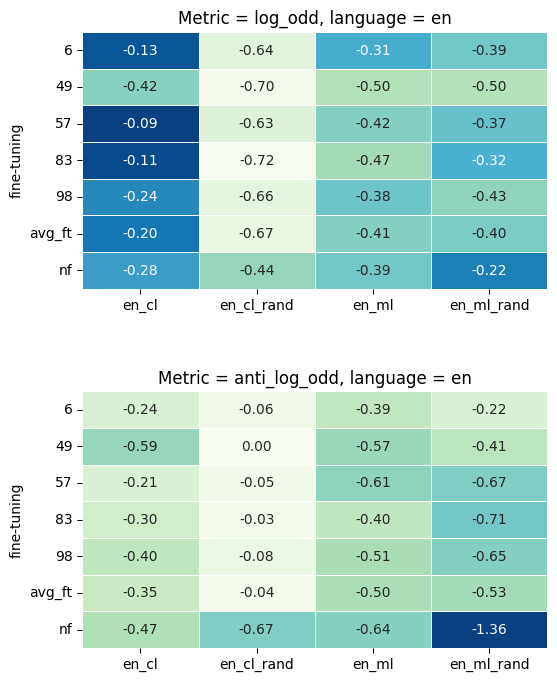

In [20]:
num_languages = 2 if 'complexity' in task else 1

fig, axes = plt.subplots(len(metrics), num_languages,  figsize=(6*num_languages, 4*len(metrics)));
axes = axes.flatten();
plt.subplots_adjust(hspace=0.4);

ax_idx = 0

for metric in metrics:
    cmap = 'GnBu'if 'anti' not in metric else 'GnBu_r'
    for language in ['en', 'it']:
        try:
            df = pd.concat(metrics_dfs[metric][language], axis=1)       
            sns.heatmap(ax=axes[ax_idx], data=df, annot=True, fmt=".2f", cmap=cmap, cbar=False, linewidth=.5, vmin=min[metric], vmax=max[metric]).set_title(label=f'Metric = {metric}, language = {language}');
            for tick in axes[ax_idx].get_yticklabels():
                tick.set_rotation(0)
            ax_idx += 1
        except:
            pass
        
fig.savefig(f'/home/luca/Workspace/augmenting_nlms_meco/output/plots/dig_{task}.png')